### check python version

In [1]:
from platform import python_version
print(python_version())
import sys
for i in range(len(sys.path)):
    #print(sys.path[i])
    continue

3.7.6


# MAIN

In [2]:
#import dlib
import os
import wave
import numpy as np
#import speech_recognition as sr
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
from pydub.effects import normalize
#import spacy
from wave import open as open_wave # for reading wave files
import pylab # for spectogram
import pandas as pd
import librosa
import parselmouth
import seaborn as sns
from scipy import stats

# IMPORTING AND PREPROCESSING OF DATA

In [48]:
data_path = "./data/"
def fetch_voice_data(url=data_path): 
    audios = []
    for audio in os.listdir(data_path):
        if audio.endswith('.wav'):
            audios.append(audio)
    return audios

#adios = fetch_voice_data()
audios = fetch_voice_data()
print(str(len(audios)) + " audio files loaded")

def file_to_npy(path_to_file):
    #audioData, sampleRate = librosa.load(path_to_file)
    #print(audioData)
    #print(audioData.shape)
    #print(sampleRate)
    y, sr = librosa.load(path_to_file, sr = 44100)
    #y, sr = librosa.load(path_to_file, mono = True, sr = 44100)
    return y

def npy_to_df(numpy_array, sample_rate, row_length, row_count):
    numpy_array = librosa.to_mono(numpy_array)
    numpy_array = numpy_array[0:sample_rate*row_length*row_count]
    rows = np.empty((0,sample_rate*row_length), int)
    for i in range(row_count):
        row = numpy_array[0:sample_rate*row_length]
        numpy_array = numpy_array[sample_rate*row_length:]
        rows = np.vstack((rows, row))
    df = pd.DataFrame((rows), columns=range(sample_rate*row_length))
    return df

def npy_to_samples(numpy_array, sample_rate, sample_length, sample_count):
    numpy_array = numpy_array[0:int(sample_rate * sample_length * sample_count)]
    samples = np.empty((0,int(sample_rate * sample_length)), int)
    for i in range(sample_count):
        sample = numpy_array[0:int(sample_rate * sample_length)]
        numpy_array = numpy_array[int(sample_rate * sample_length):]
        samples = np.vstack((samples, sample))
    return samples

def remove_silence(y):
    intervals = librosa.effects.split(y, top_db = 18)
    non_silent_audio = np.zeros(y.shape)
    for i in intervals:
        start, end = i
        non_silent_audio[start:end] = y[start:end]
    #non_silent_audio = reject_outliers(non_silent_audio)
    return non_silent_audio

def delete_silence(y):
    intervals = librosa.effects.split(y, top_db = 18)
    non_silent_audio = np.zeros(y.shape)
    for i in intervals:
        start, end = i
        non_silent_audio[start:end] = y[start:end]
    non_silent_audio = non_silent_audio[(non_silent_audio != 0)]
    return non_silent_audio

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

#remove all values further away from the mean than m-times the std deviation
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

4 audio files loaded


# main pipeline

In [57]:
sns.set() # Use seaborn's default style to make attractive graphs
y = [None] * len(audios)
sr = [None] * len(audios)
rows = []
for i in range(len(audios)):
    # load the file
    y[i], sr[i] = librosa.load(data_path + audios[i], mono = True, sr = 44100)
    
    # get the label
    label = audios[i].split(".")
    label.pop()
    label = "".join(label)
    
    # remove silent parts
    y[i] = delete_silence(y[i])
    
    # save as a file to verify
    librosa.output.write_wav("output/" + label + "-output.wav", y[i], 44100)
    
    # cut into pieces
    sample_count = 150
    sample_length = 0.2 # in seconds
    samples = npy_to_samples(y[i], 44100, sample_length, sample_count)
    
    for j in range(sample_count):
        sample = samples[j]
        # load with parselmouth
        snd = parselmouth.Sound(sample)

        # calculate the pitch
        intensity = snd.to_intensity()

        raw_intensity = intensity.values[0]
        rounded_intensity = [round(num, 0) for num in intensity.values[0]]
        mean = np.mean(raw_intensity)
        median = np.median(raw_intensity)
        mode = stats.mode(rounded_intensity)[0][0]
        mode_count = stats.mode(rounded_intensity)[1][0]
        std = np.std(raw_intensity)

        rows.append([label, mean, median, mode, mode_count, std])
    
result = pd.DataFrame(np.array(rows), columns = ["label", "mean", "median", "mode", "mode_count", "std"])
result

,label,mean,median,mode,mode_count,std
0,Daniel,69.75866673902323,68.96813061328129,75.0,4,4.090551631779817
1,Daniel,68.26755962191422,66.58331328737245,67.0,4,4.792337947292297
2,Daniel,64.57666828829767,64.76009152483437,65.0,6,1.2193344169139295
3,Daniel,69.08830283312783,69.3024698937473,66.0,3,4.495966648211337
4,Daniel,69.90451734908974,70.89639178706227,76.0,4,5.601309695448967
...,...,...,...,...,...,...
595,Richard,75.95740154791343,76.91613650234018,77.0,3,5.783900805531329
596,Richard,79.41734877459949,80.56985053564516,83.0,5,4.314214702828606
597,Richard,77.09437428269804,79.02180879496976,82.0,4,4.461904296720462
598,Richard,81.80922644779565,81.43788630313261,85.0,5,2.490831453682986


## Parselmouth (Praat)

Text(0.5, 1.0, 'sample')

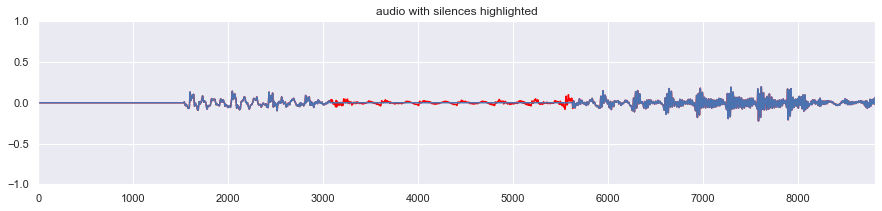

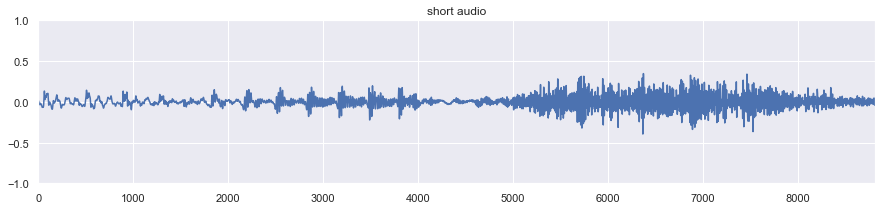

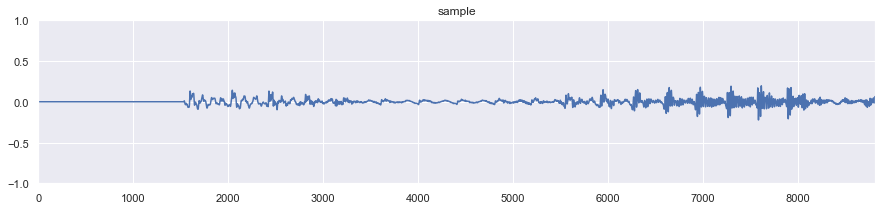

In [55]:
y = file_to_npy(data_path + audios[0])
plot_lim = int(44100*0.2)
plt.figure(figsize=[15,3])
plt.plot(y, color="red")
plt.plot(remove_silence(y))
plt.ylim(-1, 1)
plt.xlim(0, plot_lim)
plt.title('audio with silences highlighted')
a = remove_silence(y)
a = a[(a != 0)]
plt.figure(figsize=[15,3])
plt.plot(a)
plt.ylim(-1, 1)
plt.xlim(0, plot_lim)
plt.title('short audio')

samples = npy_to_samples(y, 44100, 0.2, 150)
plt.figure(figsize=[15,3])
plt.plot(samples[0])
plt.ylim(-1, 1)
plt.xlim(0, plot_lim)
plt.title('sample')


#librosa.output.write_wav("data/output.wav", a[(a != 0)], 44100)

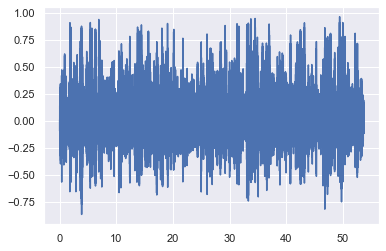

In [8]:
snd = parselmouth.Sound(a)
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.show()

#### cut each wav file into 30 1-second files

In [4]:
if not os.path.exists("parselmouth"):
    os.makedirs("parselmouth")

for i in range(len(audios)):
    for j in range(30):
        y, sr = librosa.load(data_path + audios[i], sr = 44100, duration = 1, offset = j)
        label = audios[i].split(".")
        label.pop()
        label = "".join(label)
        label = label + str(j) + ".wav"
        librosa.output.write_wav("parselmouth/" + label, y, sr)

#### plot the pitch curve from data

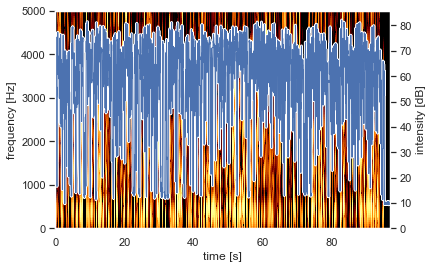

In [12]:
sns.set() # Use seaborn's default style to make attractive graphs
#snd = parselmouth.Sound("parselmouth/Daniel0.wav")
snd = parselmouth.Sound(data_path + audios[0])

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram.pdf")

In [13]:
raw_intensity = intensity.values[0]
print(len(raw_intensity))
rounded_intensity = [round(num, 0) for num in intensity.values[0]]
print("ROUNDED")
print("mean: " + str(np.mean(raw_intensity)))
print("median: " + str(np.median(raw_intensity)))
print("mode: " + str(stats.mode(rounded_intensity)[0][0]) + " count: " + str(stats.mode(rounded_intensity)[1][0]))
print("std deviation: " + str(np.std(raw_intensity)))

12118
ROUNDED
mean: 58.6962724136444
median: 64.42225618680006
mode: 66.0 count: 497
std deviation: 17.783374883023843


#### box chart of intensities

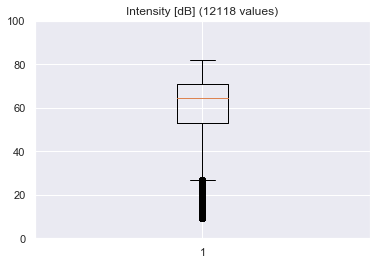

In [14]:
plt.boxplot(raw_intensity)
plt.ylim(0, 100)
plt.title("Intensity [dB] (" + str(len(raw_intensity)) + " values)")
plt.show()

#### box chart after removing outliers (silence)

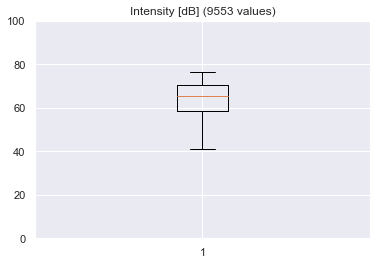

In [15]:
no_outliers = reject_outliers(raw_intensity)
plt.boxplot(no_outliers)
plt.ylim(0, 100)
plt.title("Intensity [dB] (" + str(len(no_outliers)) + " values)")
plt.show()

## wave

In [4]:
def get_audio_params(file_path):
    wav_file = wave.open(file_path, 'r')
    #print(f"channels: {wav_file.getnchannels()}")
    print(f"sample rate: {wav_file.getframerate()}")
    #print(f"frames: {wav_file.getnframes()}")
    #print(f"sample width: {wav_file.getsampwidth()}")
    #print(f"params: {wav_file.getparams()}")
    print(f"length: {wav_file.getnframes()/wav_file.getframerate()} seconds")

for audio in audios:
    print(audio)
    get_audio_params(data_path + audio)

NameError: name 'audios' is not defined

In [5]:
fileWave = open_wave(data_path + audios[0],'rb')
wframes = fileWave.getnframes()
waveFrames = fileWave.readframes(wframes)
waveData = np.frombuffer(waveFrames, dtype=np.int16)
print(len(waveData)/44100/2)

NameError: name 'data_path' is not defined

## librosa

,0,1,2,3,4,5,6,7,8,9,...,44091,44092,44093,44094,44095,44096,44097,44098,44099,name
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.005020,-0.003738,-0.005585,-0.006989,-0.003494,-0.000366,-0.007553,-0.020935,-0.029724,Daniel
1,-0.027527,-0.015503,-0.000488,0.008957,0.010986,0.012421,0.013855,0.010345,0.004242,-0.000366,...,-0.001953,-0.001266,0.000793,0.003906,0.007828,0.012222,0.016327,0.018875,0.019333,Daniel
2,0.018127,0.015778,0.012695,0.009277,0.006226,0.004837,0.004837,0.007034,0.010910,0.015503,...,-0.000778,-0.001114,0.000381,0.000381,-0.000366,-0.001160,-0.001358,-0.001587,-0.002655,Daniel
3,-0.002533,-0.000092,0.002594,0.003036,0.001312,-0.000488,-0.001373,-0.001434,0.000427,0.001343,...,0.002380,0.001480,0.000214,-0.000275,0.001114,0.002670,0.001816,0.000671,-0.001282,Daniel
4,-0.003021,-0.004456,-0.004227,-0.000122,0.004272,0.005920,0.002975,-0.001480,-0.002792,-0.000580,...,0.009933,0.001083,-0.008499,-0.010559,-0.006805,-0.001938,0.000641,-0.000137,0.001984,Daniel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.022354,0.034134,0.033646,0.021317,0.016785,0.018677,0.017273,0.007980,0.002243,0.007629,...,0.023331,0.019577,0.014038,0.008804,0.002930,-0.001678,-0.007935,-0.011429,-0.014343,Richard
26,-0.024063,-0.033142,-0.037857,-0.043915,-0.050873,-0.054214,-0.060501,-0.068039,-0.072998,-0.081909,...,0.133713,0.116440,-0.089645,-0.151749,0.024994,0.155884,0.016113,-0.141098,-0.024551,Richard
27,0.074768,0.106369,-0.028397,-0.050842,0.128342,0.024399,-0.100876,0.103622,0.047775,-0.124817,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Richard
28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.150345,0.115601,0.074570,0.033600,-0.011002,-0.050049,-0.082336,-0.111435,-0.137054,Richard


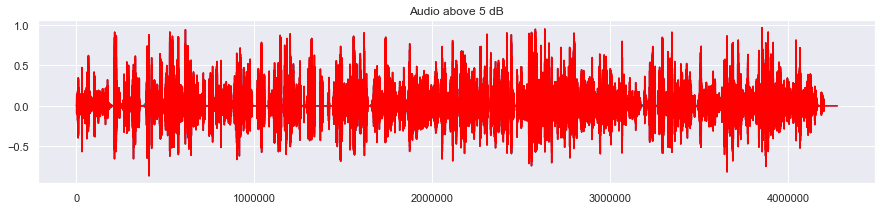

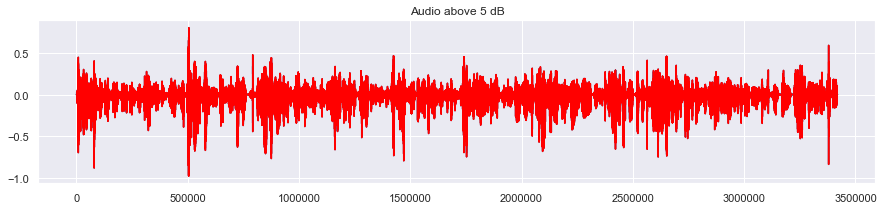

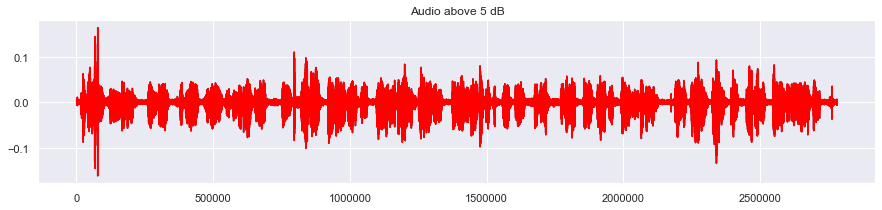

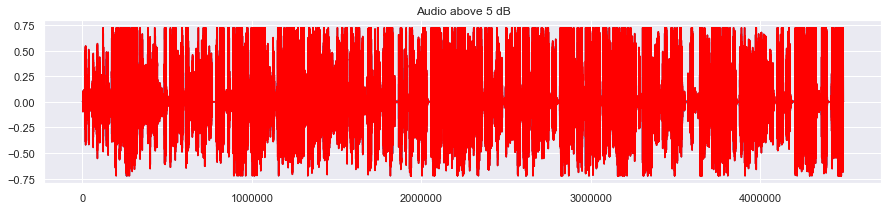

In [87]:
frames = []
# Load the audio as a waveform `y`
# Store the sampling rate as `sr`
y = [None] * len(audios)
sr = [None] * len(audios)
for i in range(len(audios)):
    y[i], sr[i] = librosa.load(data_path + audios[i], sr = 44100)
    y[i] = remove_silence(y[i])
    minidf = npy_to_df(y[i], sr[i], 1, 30)
    label = audios[i].split(".")
    label.pop()
    minidf["name"] = "".join(label)
    frames.append(minidf)
result = pd.concat(frames)
result.shape
result

# choosing the best classification model

In [18]:
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
data  =  result
#Create Dependent and Independent Datasets based on our Dependent #and Independent features
X= data[range(44100)]
y= data["name"]
#Split the Data into Training and Testing sets with test size as #20%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

In [19]:
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)

In [124]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is %s"%(clf, cm))

Accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is 0.5
Confusion Matrix of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is [[2 2 2 1]
 [1 0 2 1

## spectogram

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


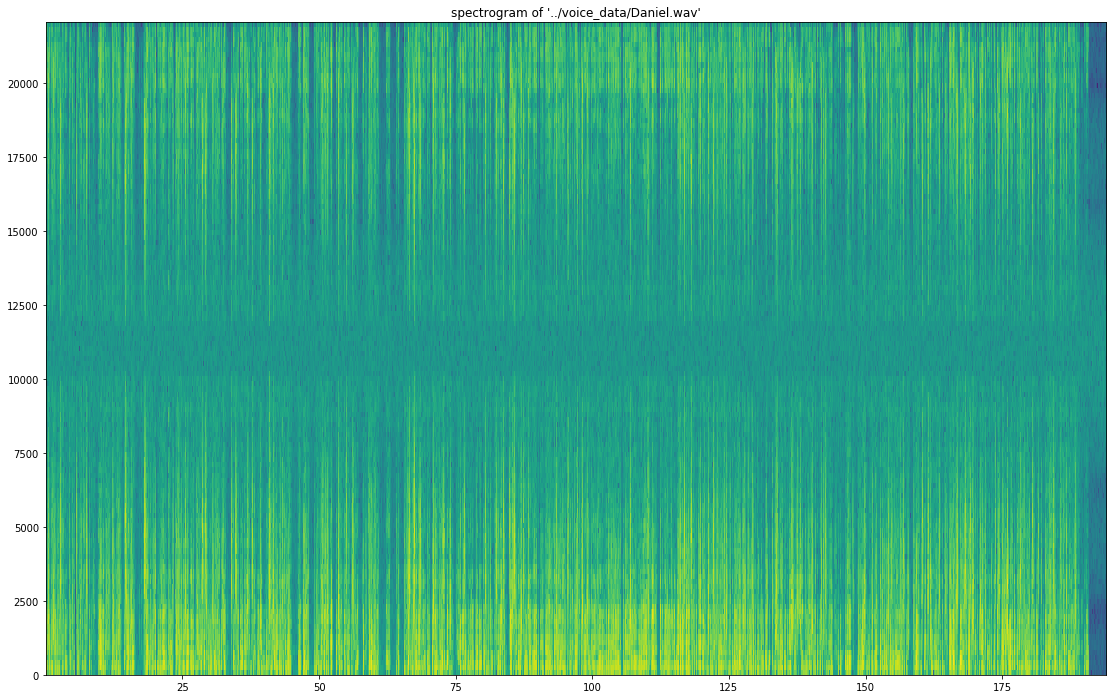

In [6]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
if __name__ == '__main__':
    wav_file = r"../voice_data/Daniel.wav"
    graph_spectrogram(wav_file)